# Predykcja dostepności rowerów Wrocławskiego Roweru Miejskiego

---

## Dane pozyskane z oficjalnej strony WWW operatora systemu.

### Notebook pokazuje możliwość predykcji szeregów czasowych za pomocą biblioteki Prophet - udostępniona jako oprogramowanie open source przez Facebook.



---


**(c) 2021 Marian Witkowski**

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson

import warnings
warnings.filterwarnings('ignore')

### Odczyt danych ze skompresowanego pliku CSV do formatu ZIP

In [2]:
df = pd.read_csv("https://github.com/marianwitkowski/python-data/raw/master/veturilo-wroc/veturilo-wroc.csv.zip", compression='zip')
df.sample(n=10)

,uid,ts,bikes
1218244,12500590,20210407234009,4.0
1990910,27524358,20210420085006,3.0
315823,12499378,20210323095002,13.0
64760,16340542,20210307194002,23.0
3097528,16336577,20210508032002,7.0
342711,16337589,20210323201008,7.0
1462795,12500399,20210411214502,5.0
3859457,16339637,20210520192002,3.0
805206,16340448,20210401082002,4.0
2943654,16334773,20210505161502,NaN


### Analizowany jest przedział czasowy od 19.04 do 23.05 roku 2021 dla stacji nr 12500340

In [5]:
START = "2021-04-19"
STOP = "2021-05-23"

df1 = df.query(" uid=='12500340' ")
df1.ts = pd.to_datetime(df1.ts, format="%Y%m%d%H%M%S")
df1.set_index("ts", inplace=True)
df1.drop(columns="uid", inplace=True)
df1.columns = ['qnty']

df1 = df1.loc[START:STOP]

df1

,qnty
ts,
2021-04-19 00:00:06,1.0
2021-04-19 00:05:06,1.0
2021-04-19 00:10:06,13.0
2021-04-19 00:15:04,13.0
2021-04-19 00:20:05,13.0
...,...
2021-05-23 23:35:01,3.0
2021-05-23 23:40:01,3.0
2021-05-23 23:45:01,3.0


### Elimiancja wartości NaN

In [6]:
df1.qnty = df1.fillna(method='ffill').astype('uint8')

### Poglądowy wykres

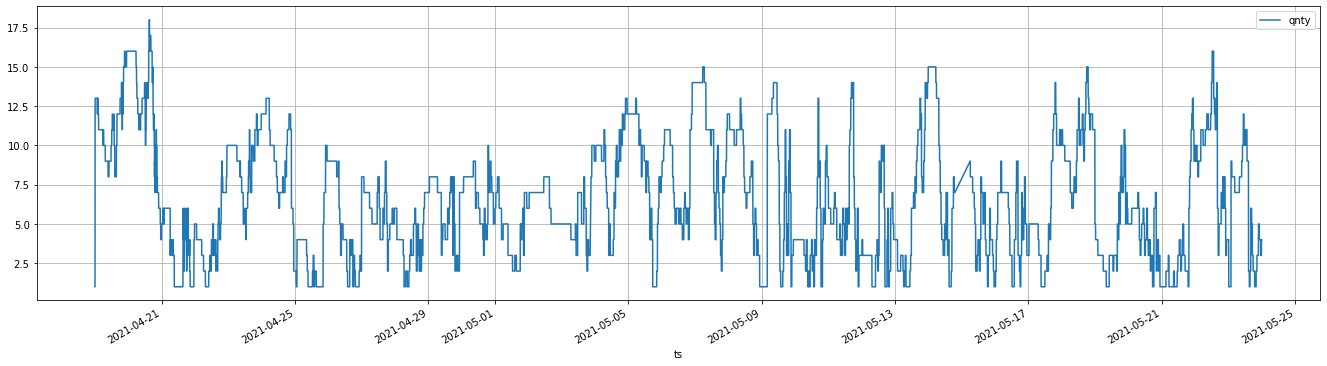

In [8]:
df1.plot(figsize=(23,6), grid=True)
plt.show()

### Zestawienie danych "tydzień do tygodnia" i projekcja średniej kroczącej w celu analizy trendu

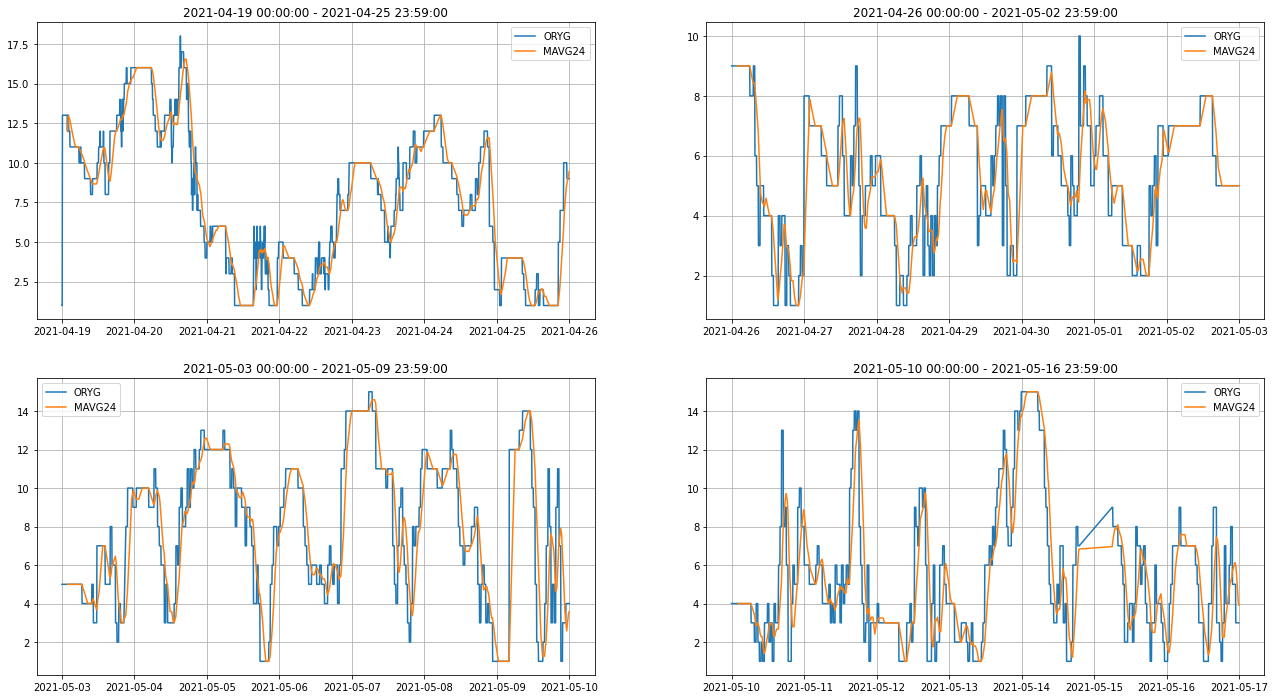

In [10]:
dates = pd.date_range(START, STOP, freq='7D')
print(dates)

plots = len(dates)-1
if plots%2!=0: plots -= 1
cols = 2
rows = plots // cols
plt.subplots(rows, cols, figsize=(22,12))

for x in range(plots):
  start, stop = str(dates[x]), str(dates[x+1]-np.timedelta64(1, 'm'))
  plt.subplot(rows, cols, x+1)
  df_tmp = df1.loc[start:stop]
  plt.title(f"{start} - {stop}")
  plt.plot(df_tmp.index, df_tmp.qnty)
  plt.plot(df_tmp.index, df_tmp.qnty.rolling(24).mean())
  plt.grid()
  plt.legend(['Wart. rzeczywista','Średnia krocząca 2-godzinowa'])



### Sprawdzenie autokorelacji szeregu czasowego i test Durbina-Watsona

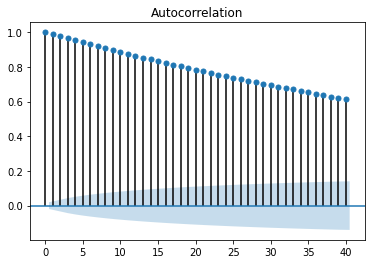

0.0064542131302839515


In [29]:
plot_acf(df1.qnty)
plt.show()

print(durbin_watson(df1.qnty))

### Instalacja biblioteki Prophet

In [14]:
!pip -q install fbprophet

In [15]:
from fbprophet import Prophet

### Jako przedział do analizy brany jest okres poza 3 ostatnimi dniami, dla których zostanie wykonana predykcja a następnie porównana z danymi rzeczywistymi

2021-05-14 00:00:00


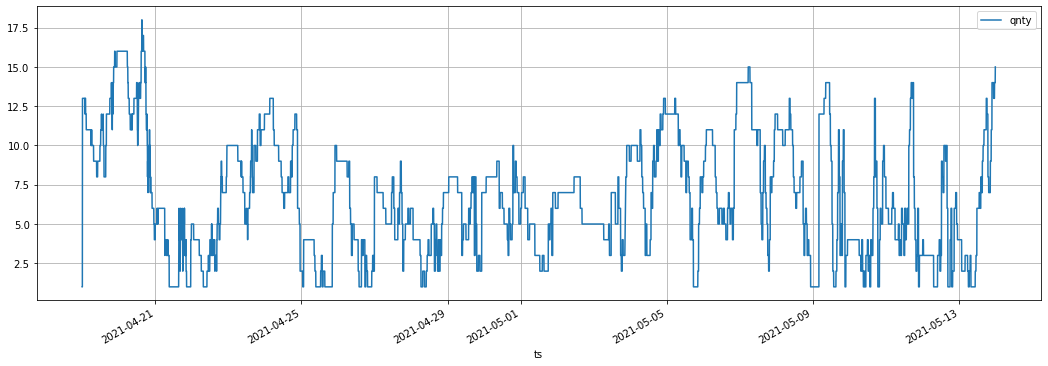

In [16]:
DAYS = 3
end_pred = str( dates[-1] - np.timedelta64(DAYS, 'D') )
print(end_pred)

df_predict = df1.loc[:end_pred]
df_predict.plot(figsize=(18,6), grid=True)
plt.show()

### Przygotowanie danych na potrzeby biblioteki Prophet

In [17]:
df_predict.reset_index(inplace=True)
df_predict.columns = ['ds','y']
df_predict.head()

,ds,y
0,2021-04-19 00:00:06,1
1,2021-04-19 00:05:06,1
2,2021-04-19 00:10:06,13
3,2021-04-19 00:15:04,13
4,2021-04-19 00:20:05,13


### Wykonanie predykcji w okresach godzinowych dla 3 następnych dni

In [18]:
model = Prophet()
model.fit(df_predict)
future = model.make_future_dataframe(periods=24*DAYS, freq='H')
forecast = model.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


### Zawartość obiektu z danymi predykcyjnymi, w tym przewidywane zakresy min/max w okresach dziennych i tygodniowych

In [22]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [23]:
forecast[ ['ds','yhat','yhat_lower', 'yhat_upper'] ]

,ds,yhat,yhat_lower,yhat_upper
0,2021-04-19 00:00:06,13.725043,10.320503,17.195442
1,2021-04-19 00:05:06,13.704927,10.143821,17.359766
2,2021-04-19 00:10:06,13.682937,10.008263,17.295571
3,2021-04-19 00:15:04,13.659452,10.199836,17.446095
4,2021-04-19 00:20:05,13.634298,9.976591,17.252825
...,...,...,...,...
7245,2021-05-16 19:55:05,2.612885,-1.310136,6.722979
7246,2021-05-16 20:55:05,2.961719,-1.234827,7.143876
7247,2021-05-16 21:55:05,3.624484,-0.415918,7.687756
7248,2021-05-16 22:55:05,4.144157,0.125997,8.347627


In [33]:
df_tmp = forecast[ ['ds','yhat','yhat_lower', 'yhat_upper'] ].set_index('ds').loc[end_pred:]

### Wizualizacja predykcji

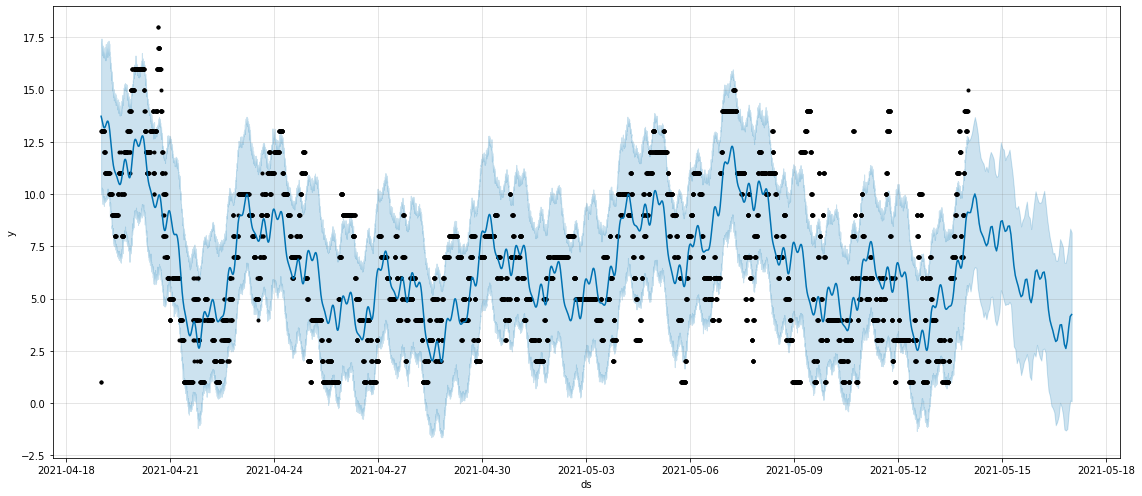

In [40]:
model.plot(forecast, figsize=(16,7))
plt.show()

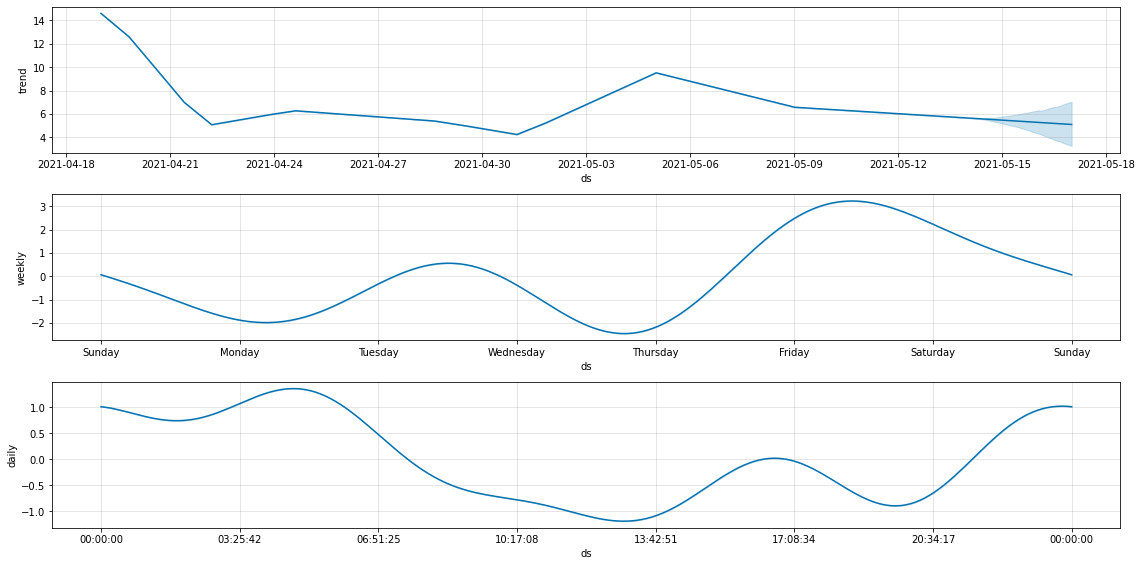

In [24]:
model.plot_components(forecast, figsize=(16,8))
plt.show()

### Porównanie wartości predyktowanej z wartością rzeczywistą dla ostatnich 3 dni zakresu pomiarowego

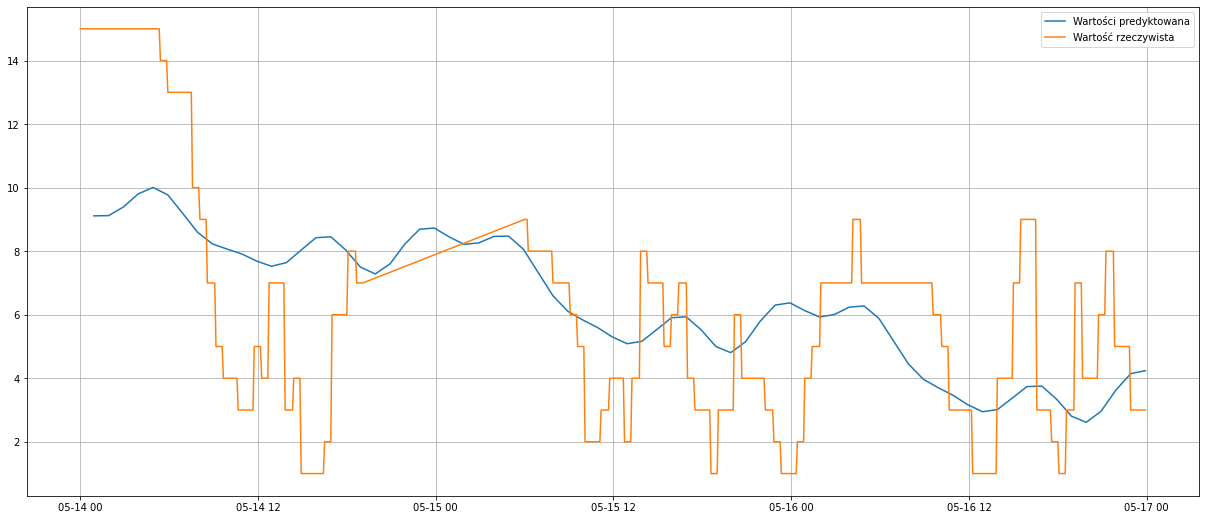

In [32]:

plt.figure(figsize=(21,9))
plt.plot(df_tmp.index, df_tmp.yhat, label="Wartości predyktowana")
plt.plot(df1.loc[end_pred:str(dates[-1])].index, df1.loc[end_pred:str(dates[-1])].qnty, label="Wartość rzeczywista" )
plt.grid()
plt.legend()
plt.show()
